<a href="https://colab.research.google.com/github/kishan4935/spam_e-mail_prediction/blob/main/spam_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow_text

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/My personal project/spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

## 15% spam emails, 85% ham emails: This indicates class imbalance

In [5]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [6]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [7]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [8]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape


(1494, 2)

In [9]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [10]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
358,spam,Ur cash-balance is currently 500 pounds - to m...,1
4879,spam,No 1 POLYPHONIC tone 4 ur mob every week! Just...,1
4413,ham,If i said anything wrong sorry de:-),0
192,ham,I'm sorry. I've joined the league of people th...,0
4063,ham,Hi dear we saw dear. We both are happy. Where ...,0


### Split it into training and test data set

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [12]:
X_train.head(4)


5549    You know, wot people wear. T shirts, jumpers, ...
95      Your free ringtone is waiting to be collected....
385     Double mins and txts 4 6months FREE Bluetooth ...
1864                   I'll let you know when it kicks in
Name: Message, dtype: object

### Now lets import BERT model and get embeding vectors for few sample statements

In [13]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [14]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']



In [15]:
get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.51327264, -0.88845724, ..., -0.74748874,
        -0.75314736,  0.91964483],
       [-0.8720836 , -0.5054398 , -0.9444668 , ..., -0.85847515,
        -0.7174535 ,  0.88082975]], dtype=float32)>

### Get embeding vectors for few sample words. Compare them using cosine similarity

In [16]:
# few examples
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

In [18]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703845]], dtype=float32)

### Build Model
#### There are two types of models you can build in tensorflow.
#### (1) Sequential (2) Functional

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [19]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [23]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]


In [24]:

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

### Train the model

In [26]:
model.fit(X_train, y_train, epochs=4)

Epoch 1/4
35/35 [==============================] - 499s 14s/step - loss: 0.5421 - accuracy: 0.7714 - precision: 0.7460 - recall: 0.8232
Epoch 2/4
35/35 [==============================] - 499s 14s/step - loss: 0.4537 - accuracy: 0.8527 - precision: 0.8508 - recall: 0.8554
Epoch 3/4
35/35 [==============================] - 494s 14s/step - loss: 0.4110 - accuracy: 0.8705 - precision: 0.8559 - recall: 0.8911
Epoch 4/4
35/35 [==============================] - 501s 14s/step - loss: 0.3803 - accuracy: 0.8813 - precision: 0.8637 - recall: 0.9054


In [27]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 165s 14s/step - loss: 0.3598 - accuracy: 0.8850 - precision: 0.8750 - recall: 0.8984


[0.3597947359085083, 0.885026752948761, 0.875, 0.8983957171440125]

In [28]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 182s 15s/step


In [29]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[163,  24],
       [ 19, 168]])

Text(33.0, 0.5, 'Truth')

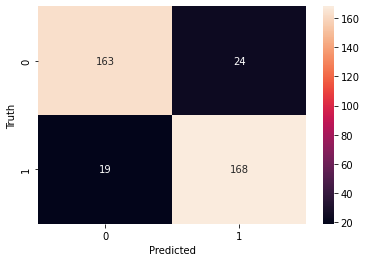

In [31]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [37]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       187
           1       0.88      0.90      0.89       187

    accuracy                           0.89       374
   macro avg       0.89      0.89      0.89       374
weighted avg       0.89      0.89      0.89       374



###inference

In [38]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 4s 4s/step


array([[0.5848611 ],
       [0.68544114],
       [0.6222387 ],
       [0.23447855],
       [0.1962691 ]], dtype=float32)

In [40]:
reviews = [
    "5 Star Saturday: Become a Verified Candidate"
]
model.predict(reviews)

1/1 [==============================] - 1s 908ms/step


array([[0.39982188]], dtype=float32)

In [47]:
reviews = [
   '30+ new jobs for “Software Engineer”'


]
model.predict(reviews)

1/1 [==============================] - 1s 714ms/step


array([[0.12046023]], dtype=float32)